<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Salvus</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Input and Output</div>
        </div>
    </div>
</div>

In [1]:
%matplotlib inline

# Import modules and setup paths.
import os
import h5py
import matplotlib.pyplot as plt
import pyasdf

# Paths are grabbed from environment variables.
PARAVIEW_BIN = os.environ["PARAVIEW_BIN"]
SALVUS_BIN = os.environ["SALVUS_BIN"]

MESH2D = "Quad_IsotropicElastic2D_Nodal_44x44.e"
MESH3D = "Hex_IsotropicElastic3D_Nodal_7x7x7.e"

# Advanced input and output

In this example we will use advanced options to specify sources and receivers and explore various options for wavefield data output. We start with a very simple example of a single source-receiver pair in a homogeneous medium. 
The path to the mesh is also stored in the `HOMOGENEOUS_MESH` variable defined above. Open the file with `Paraview` and explore its contents.

In [2]:
!$PARAVIEW_BIN $MESH2D

You should already be familiar with `Paraview`, so just make sure that the model is indeed homogeneous by checking the values of `RHO`, `LAMBDA`, `MU`, `VP` and `VS`. Why are there 5 different parameters you ask? Good question. Of course, in an isotropic medium we have the relations

$$
v_p = \sqrt{\frac{\lambda + 2\mu}{\rho}},\quad\quad v_s = \sqrt{\frac{\mu}{\rho}},
$$

but for convenience we added the other fields as well. Let's check whether the values are consistent by using the `Calculator` filter in `Paraview`. From the top menu select `Filters -> Data Analysis -> Calculator`. 
In the panel on the left you can now define pointwise operations on the parameter fields. For instance, type `VS_check` in the field `Result Array Name` and put `sqrt(MU/RHO)` in the line below. After clicking on `Apply` you can now select `VS_check` from the dropdown menu on the top an plot the new field. The values should be the same as in `VS`. Repeat the same steps to check whether `VP` is also consistent with `LAMBDA` and `MU`.

Next, we need to decide where to put the source and the receiver in this example. Scroll down the property panel and tick the checkbox `Axes Grid`. You will see that our domain is given by `[-1000,1000] x [0,2000]`. So let's put the source at `[-500,1000]` and the receiver at `[500,1000]`.


### Source and receiver input

You can specify almost all input parameters using the command line. However, this gets really tedious when dealing with many sources and receivers. Fortunately, there is another way using a `toml` file. `toml` is a minimal configuration file format that is easy to read and to parse. A receiver needs at least to set the `network` and `station` name following the SEED format (http://www.fdsn.org/seed_manual/SEEDManual_V2.4.pdf). Furthermore, we need to specify whether the receiver is in fluid or solid media and its location, of course. This is how the `toml` file can be created:




In [3]:
with open("salvus.toml", "w") as text_file:
    recLocX = 500
    recLoxY = 1000
    print("\n[[receiver]]", file=text_file)
    print("network = \"AB\"", file=text_file)
    print("station = \"CED\"", file=text_file)
    print("medium = \"solid\"", file=text_file)
    print("salvus_coordinates = [{0}, {1}]".format(recLocX, recLoxY), file=text_file)
    
    recLocX = 600
    recLoxY = 1000
    print("\n[[receiver]]", file=text_file)
    print("network = \"AB\"", file=text_file)
    print("station = \"CEF\"", file=text_file)
    print("medium = \"solid\"", file=text_file)
    print("salvus_coordinates = [{0}, {1}]".format(recLocX, recLoxY), file=text_file)

In [4]:
! cat salvus.toml


[[receiver]]
network = "AB"
station = "CED"
medium = "solid"
salvus_coordinates = [500, 1000]

[[receiver]]
network = "AB"
station = "CEF"
medium = "solid"
salvus_coordinates = [600, 1000]


Check the contents of the file and make sure it contains the correct values. 

Now it's time to run a simulation.

In [5]:
!$SALVUS_BIN --mesh-file $MESH2D --model-file $MESH2D \
 --polynomial-order 4 --dimension 2 --end-time 1.04 \
 --cmd-line-source --source-temporal-type ricker \
 --source-spatial-type vector \
 --source-location-x -500 --source-location-y 1000 \
 --source-scale 1e9,1e9 --source-center-frequency 14.5 \
 --receiver-toml salvus.toml --receiver-file-name receiver.h5 \
 --receiver-fields u_ELASTIC


Salvus version 0.0.1-974-g7237b8b
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

--source-time-delay not set. Will auto-calculate.
Initializing problem.
Start time set to -0.107544.
Time step set to: 0.000735822 s.
Start time set to -0.107544.
Begin time loop.
Time loop progress [100%].
Time loop completed in 5.3575 seconds.
Begin post processing.
Problem complete.



Did it work? If you are not sure check the contents of `receiver.h5`:

In [6]:
! h5dump -H receiver.h5

HDF5 "receiver.h5" {
GROUP "/" {
   ATTRIBUTE "file_format" {
      DATATYPE  H5T_STRING {
         STRSIZE 4;
         STRPAD H5T_STR_NULLPAD;
         CSET H5T_CSET_ASCII;
         CTYPE H5T_C_S1;
      }
      DATASPACE  SCALAR
   }
   ATTRIBUTE "file_format_version" {
      DATATYPE  H5T_STRING {
         STRSIZE 5;
         STRPAD H5T_STR_NULLPAD;
         CSET H5T_CSET_ASCII;
         CTYPE H5T_C_S1;
      }
      DATASPACE  SCALAR
   }
   GROUP "Waveforms" {
      GROUP "AB.CED" {
         
         DATASET "AB.CED..XDX__1970-01-01T00:00:00__1970-01-01T00:00:01__displacement" {
            DATATYPE  H5T_IEEE_F64LE
            DATASPACE  SIMPLE { ( 1561 ) / ( 1561 ) }
            ATTRIBUTE "sampling_rate" {
               DATATYPE  H5T_IEEE_F64LE
               DATASPACE  SIMPLE { ( 1 ) / ( 1 ) }
            }
            ATTRIBUTE "starttime" {
               DATATYPE  H5T_STD_I64LE
               DATASPACE  SIMPLE { ( 1 ) / ( 1 ) }
            }
         }
         
         DA

Well, at least the traces are there. But better to plot the traces instead. Try it yourself using `pyasdf`.

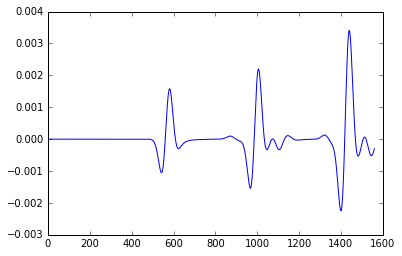

In [7]:
with pyasdf.ASDFDataSet("receiver.h5") as ds:
    plt.plot(ds.waveforms.AB_CED.displacement[0].data)

**Can you explain the different wave fronts you see in the seismgram? Where do they come from?**



To verify your assumption we will visualize the entire wavefield in the next section. But before we continue, let's reduce the number of command line options for the source.

Similarly to the receivers, we can define one or more sources in a `toml` file instead of passing all the options to the command line. 
Salvus can transform spherical coordinates into the internally used cartesian coordinates, but this currently only works for receivers and not for sources. Thus, the `toml` field for sources is called just `location` instead of `salvus_coordinates`.

In [8]:
with open("salvus.toml", "a") as text_file:
    name = "source1"
    srcLocX = -500.0
    srcLocY = 1000.0
    spatial_type = "vector"
    temporal_type = "ricker"
    scaleX = 1e9
    scaleY = 1e9
    center_frequency = 14.5
    print("\n[[source]]", file=text_file)
    print("name = \"{0}\"".format(name), file=text_file)
    print("location = [{0}, {1}]".format(srcLocX, srcLocY), file=text_file)
    print("spatial_type = \"{0}\"".format(spatial_type), file=text_file)
    print("temporal_type = \"{0}\"".format(temporal_type), file=text_file)
    print("center_frequency = {0}".format(center_frequency), file=text_file)
    print("scale = [{0}, {1}]".format(scaleX,scaleY), file=text_file)

Note that we append the sources to the same `toml` file, so be careful when you run this cell several times.

In [9]:
!$SALVUS_BIN --mesh-file $MESH2D --model-file $MESH2D \
 --polynomial-order 4 --dimension 2 --end-time 1.04 \
 --source-toml salvus.toml \
 --receiver-toml salvus.toml --receiver-file-name receiver1.h5 \
 --receiver-fields u_ELASTIC


Salvus version 0.0.1-974-g7237b8b
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

Initializing problem.
Start time set to -0.107544.
Time step set to: 0.000735822 s.
Start time set to -0.107544.
Begin time loop.
Time loop progress [100%].
Time loop completed in 5.40511 seconds.
Begin post processing.
Problem complete.



Plot and compare both receiver.

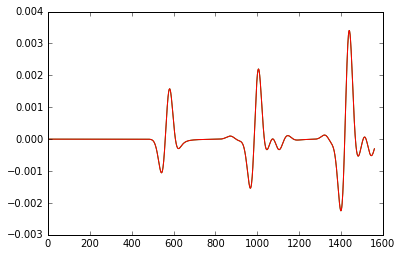

In [10]:
with pyasdf.ASDFDataSet("receiver.h5") as ds, \
        pyasdf.ASDFDataSet("receiver1.h5") as ds1:
 plt.plot(ds.waveforms.AB_CED.displacement.select(component="X")[0].data, color="green")
 plt.plot(ds1.waveforms.AB_CED.displacement.select(component="X")[0].data, color="red")

The traces should be exactly the same.

### Wavefield output

#### Volume data

So far, we have generated receiver data with Salvus and visualized the wavefield using the `--save-movie` option.
Now, it is time to learn another way to output general wavefield data with Salvus.

`--save-movie` has two limitations: You can only output the wavefield at the vertices of the elements, but not at all the GLL points, which means that you are missing 117 of 125 points for a 4th-order hexahedral. Second, `--save-movie` is restricted to output only one field at the time. Instead, we will use the option `--save-fields` now. 

With `--save-fields` you can output a variety of different fields (displacement, velocities, ...) to an `hdf5` file and Salvus will automatically create an `xdmf` file for you to visualize the data with `Paraview`. So no need to call `petsc_gen_xdmf.py` anymore. However, one drawback at this stage is that Salvus only outputs the elemental data at all GLL points, but no topology. So you need to apply an interpolation filter (i.e. Delaunay 2D/3D) to obtain a continous field.

In addition, we need to define the output file using `--save-wavefield-file` (e.g., `wavefield.h5`) and, optionally, the sampling rate with `--io-sampling-rate-volume`.

In [11]:
!$SALVUS_BIN --mesh-file $MESH2D --model-file $MESH2D \
 --polynomial-order 4 --dimension 2 --end-time 1.04 \
 --source-toml salvus.toml \
 --receiver-toml salvus.toml \
 --receiver-file-name receiver.h5 --receiver-fields u_ELASTIC \
 --save-fields u_ELASTIC --save-wavefield-file "wavefield.h5" --io-sampling-rate-volume 10


Salvus version 0.0.1-974-g7237b8b
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

Initializing problem.
Start time set to -0.107544.
Time step set to: 0.000735822 s.
Start time set to -0.107544.
Begin time loop.
Time loop progress [100%].
Time loop completed in 5.45745 seconds.
Begin post processing.
Problem complete.



Let's check the contents of the current folder. You should see the files `wavefield.h5` and `wavefield_ELASTIC.xdmf`

In [12]:
! ls -l

total 121524
-rw-rw-r-- 1 boehm boehm     16222 Sep 29 11:09 curldiv0.png
-rw-rw-r-- 1 boehm boehm     56304 Sep 29 11:09 curldiv1.png
-rw-rw-r-- 1 boehm boehm     56225 Sep 29 11:09 curldiv2.png
-rw-rw-r-- 1 boehm boehm     87008 Sep 29 11:09 Hex_IsotropicElastic3D_Nodal_7x7x7.e
-rw-rw-r-- 1 boehm boehm     19908 Nov  9 00:16 IO_in_Salvus.ipynb
-rw-rw-r-- 1 boehm boehm    261024 Sep 29 11:09 Quad_IsotropicElastic2D_Nodal_44x44.e
-rw-rw-r-- 1 boehm boehm     61112 Nov  9 00:16 receiver1.h5
-rw-rw-r-- 1 boehm boehm     59704 Nov  9 00:16 receiver.h5
-rw-rw-r-- 1 boehm boehm       357 Nov  9 00:16 salvus.toml
-rw-rw-r-- 1 boehm boehm    444313 Nov  9 00:15 surface_data.pvsm
-rw-rw-r-- 1 boehm boehm    106191 Sep 29 11:09 surface_snapshot.png
-rw-rw-r-- 1 boehm boehm    224215 Nov  9 00:14 wavefield_ELASTIC_BND.xdmf
-rw-rw-r-- 1 boehm boehm    155801 Nov  9 00:16 wavefield_ELASTIC.xdmf
-rw-rw-r-- 1 boehm boehm 122868104 Nov  9 00:16 wavefield.h5


Now let's open the `xdmf` file with Paraview. You can either look at the point cloud or apply the `Delaunay 2D` filter `Filters -> Alphabetical -> Delaunay 2D`.

In [13]:
! $PARAVIEW_BIN wavefield_ELASTIC.xdmf

Ah, we forgot to set absorbing boundaries! That's why the seismograms looked messy.

In [14]:
!$SALVUS_BIN --mesh-file $MESH2D --model-file $MESH2D \
 --polynomial-order 4 --dimension 2 --end-time 1.04 \
 --source-toml salvus.toml \
 --receiver-toml salvus.toml --receiver-file-name receiver.h5 --receiver-fields u_ELASTIC \
 --absorbing-boundaries x0,x1,y0,y1 \
 --save-fields u_ELASTIC --save-wavefield-file "wavefield.h5" --io-sampling-rate-volume 10


Salvus version 0.0.1-974-g7237b8b
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

Initializing problem.
Start time set to -0.107544.
Time step set to: 0.000735822 s.
Start time set to -0.107544.
Begin time loop.
Time loop progress [100%].
Time loop completed in 6.45028 seconds.
Begin post processing.
Problem complete.



Check the wavefield and the receiver again.

In [15]:
!$PARAVIEW_BIN wavefield_ELASTIC.xdmf

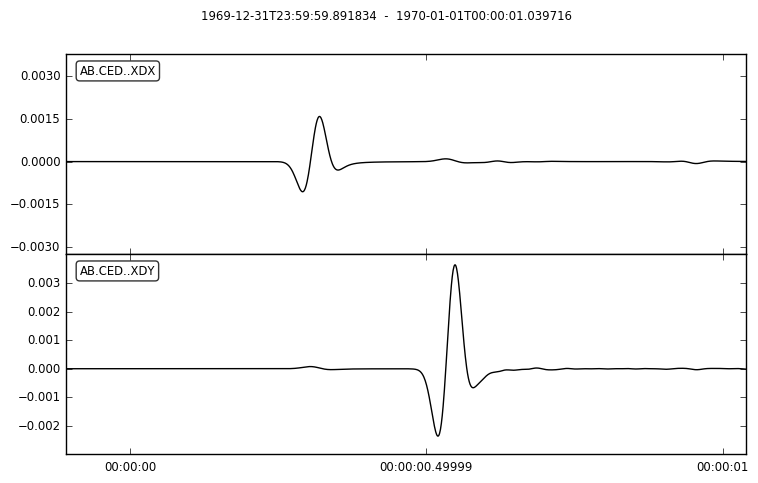

In [16]:
with pyasdf.ASDFDataSet("receiver.h5") as ds:
    ds.waveforms.AB_CED.displacement.plot()

Until now, we only looked at the displacement fields. But you can output other fields easily with `--save-fields`, e.g., velocities (`v_ELASTIC`), strains (`strain`) or the full gradient (`grad`). Let's give it a try with the gradient to compute curl and divergence.

In [17]:
!$SALVUS_BIN --mesh-file $MESH2D --model-file $MESH2D \
 --polynomial-order 4 --dimension 2 --end-time 1.04 \
 --source-toml salvus.toml \
 --receiver-toml salvus.toml --receiver-file-name receiver.h5 --receiver-fields u_ELASTIC \
 --absorbing-boundaries x0,x1,y0,y1 \
 --save-fields grad --save-wavefield-file "wavefield.h5" --io-sampling-rate-volume 100


Salvus version 0.0.1-974-g7237b8b
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

Initializing problem.
Start time set to -0.107544.
Time step set to: 0.000735822 s.
Start time set to -0.107544.
Begin time loop.
Time loop progress [100%].
Time loop completed in 6.29202 seconds.
Begin post processing.
Problem complete.



Let's look at the contents of the `h5` file.

In [18]:
! h5ls -rv wavefield.h5

Opened "wavefield.h5" with sec2 driver.
/                        Group
    Location:  1:96
    Links:     1
/ELASTIC                 Group
    Location:  1:800
    Links:     1
/ELASTIC/coordinates     Dataset {1936/1936, 25/25, 2/2}
    Location:  1:1832
    Links:     1
    Storage:   774400 logical bytes, 774400 allocated bytes, 100.00% utilization
    Type:      native double
/ELASTIC/data            Dataset {17/17, 1936/1936, 4/4, 25/25}
    Attribute: DIMENSION_LABELS {4}
        Type:      variable-length null-terminated ASCII string
        Data:  "time", "element",
               "[ grad_CMP_XX | grad_CMP_XY | grad_CMP_YX | grad_CMP_YY ]",
               "point"
    Location:  1:777144
    Links:     1
    Storage:   26329600 logical bytes, 26329600 allocated bytes, 100.00% utilization
    Type:      native double
/ELASTIC/globalElementIds Dataset {1936/1936}
    Location:  1:776872
    Links:     1
    Storage:   7744 logical bytes, 7744 allocated bytes, 100.00% utilization
 

**Can you find the related field names?**

They are called `grad_CMP_XX`, `grad_CMP_XY`, `grad_CMP_YX` and `grad_CMP_YY`.

Now open the file in paraview and use the `Calculator` filter to compute curl and divergence.
In case you don't remember, they are defined as follows in 2D
$$
\text{div}~u = \frac{\partial u_1}{\partial x_1} + \frac{\partial u_2}{\partial x_2},
$$
$$
\text{curl}~u = \frac{\partial u_2}{\partial x_1} - \frac{\partial u_1}{\partial x_2}.
$$


In [19]:
!$PARAVIEW_BIN wavefield_ELASTIC.xdmf

![divergence and curl, snapshot1](curldiv0.png)
![divergence and curl, snapshot2](curldiv1.png)
![divergence and curl, snapshot3](curldiv2.png)

By the way, you could use the same field tags for the `receiver-fields` as well in case you want to measure rotations, for instance.

#### Boundary data

In many applications, for instance, ambient noise tomography, we are only interested in the wavefield at the surface of the Earth. It would be a waste to store the wavefield everywhere and very inefficient to use a huge number of receivers for that, right?

This is why Salvus allows you to output boundary data at arbitrary boundaries. Again, you are free to choose which fields you want to plot. How about velocities?

The relevant options are:
`--save-boundary-fields` and `--save-boundaries` to specify which fields to store and where.

Of course, it is more interesting to look at boundary data in 3D. So we need a new mesh for this.

This is a simple 3D mesh with 343 elements. Put a source in the center of the domain and use a simulation time of 25 s and frequency of 0.1 Hz. You are free to choose which boundary you want to save, but we recommend to use `z1`. 

In [20]:
!$SALVUS_BIN --mesh-file $MESH3D --model-file $MESH3D \
 --polynomial-order 4 --dimension 3 --end-time 25 --cmd-line-source \
 --source-temporal-type ricker --source-spatial-type vector \
 --source-location-x 50000 --source-location-y 50000 --source-location-z 50000 \
 --source-scale 0,0,1e9 --source-center-frequency 0.1 \
 --absorbing-boundaries x0,x1,y0,y1,z0 \
 --save-boundary-fields v_ELASTIC --save-boundaries z1 \
 --io-sampling-rate-boundary 2 \
 --save-fields v_ELASTIC --io-sampling-rate-volume 2


Salvus version 0.0.1-974-g7237b8b
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

--save-wavefield-file not specified. Using default: wavefield.h5
--save-boundaries-file not specified. Using default: wavefield.h5
--source-time-delay not set. Will auto-calculate.
Initializing problem.
Start time set to -15.593936.
Time step set to: 0.127591 s.
Start time set to -15.593936.
Begin time loop.
Time loop progress [100%].
Time loop completed in 2.25019 seconds.
Begin post processing.
Problem complete.



Open `Paraview` and then click on `File -> Load State` and select the file `surface_data.pvsm`. Make sure to adjust the paths to your local computer!

In [21]:
!$PARAVIEW_BIN

![surface data snapshot](surface_snapshot.png)

Alright, that's it. Enough colorful pictures. Now it's time for some math.

### Fin.